Parsed 6697 data points.


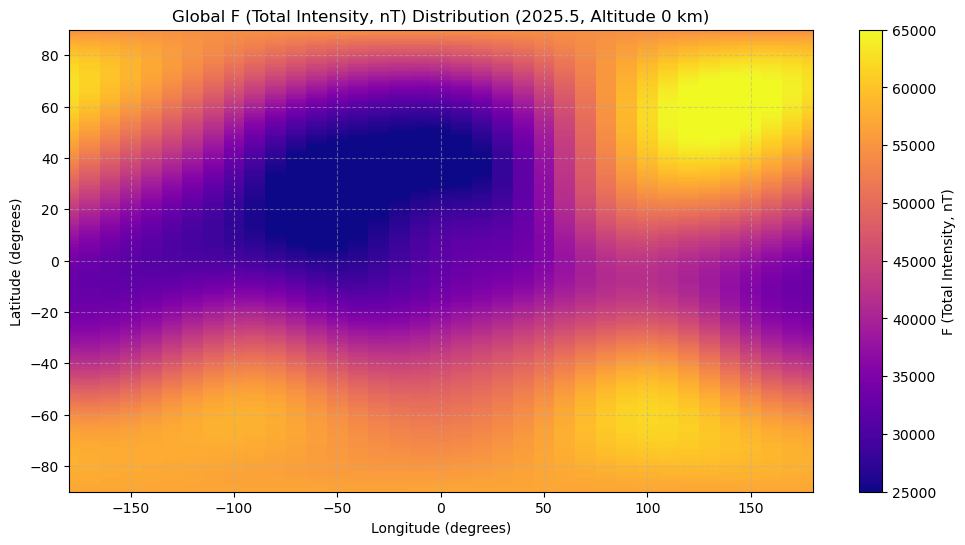

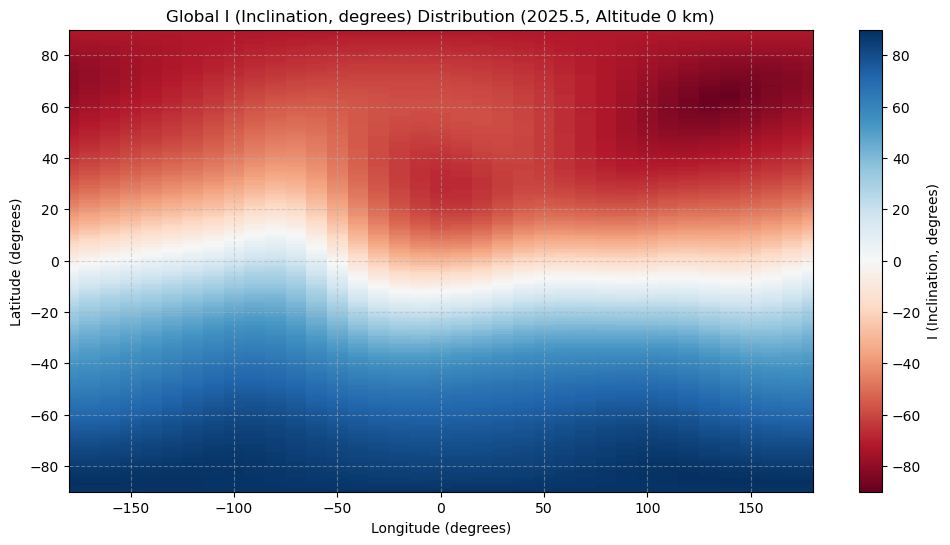

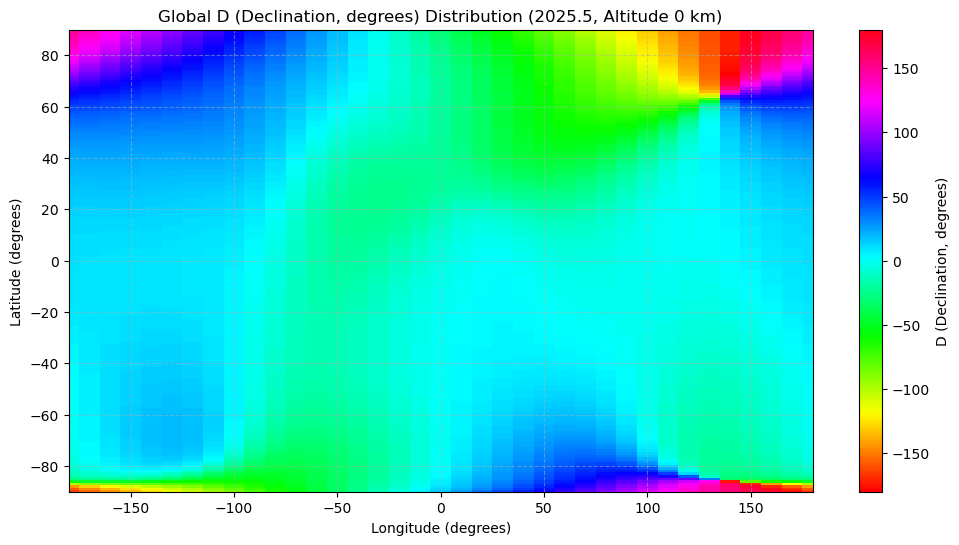

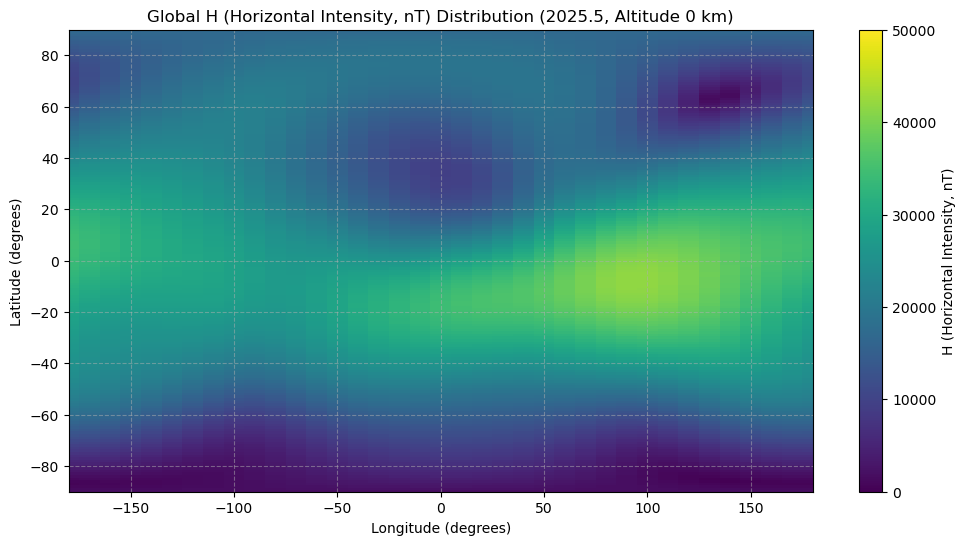

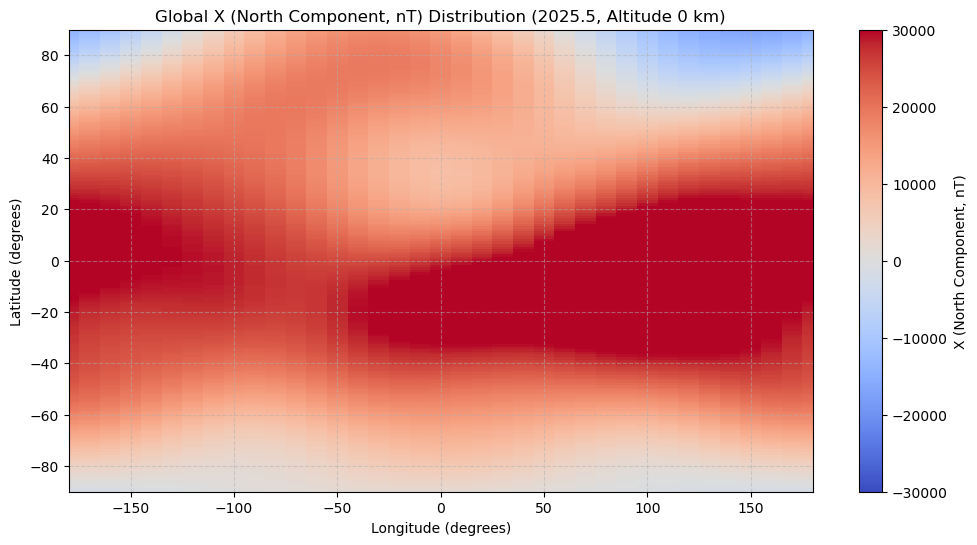

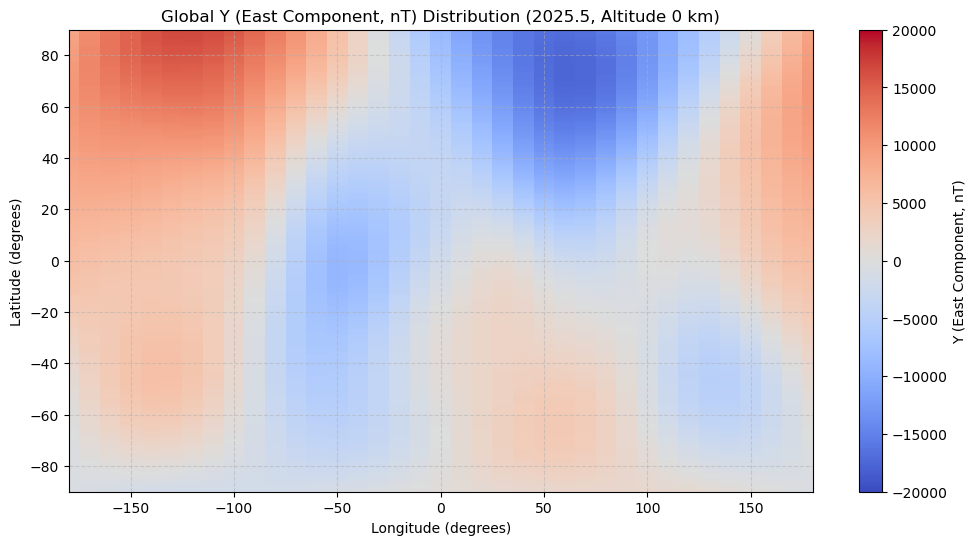

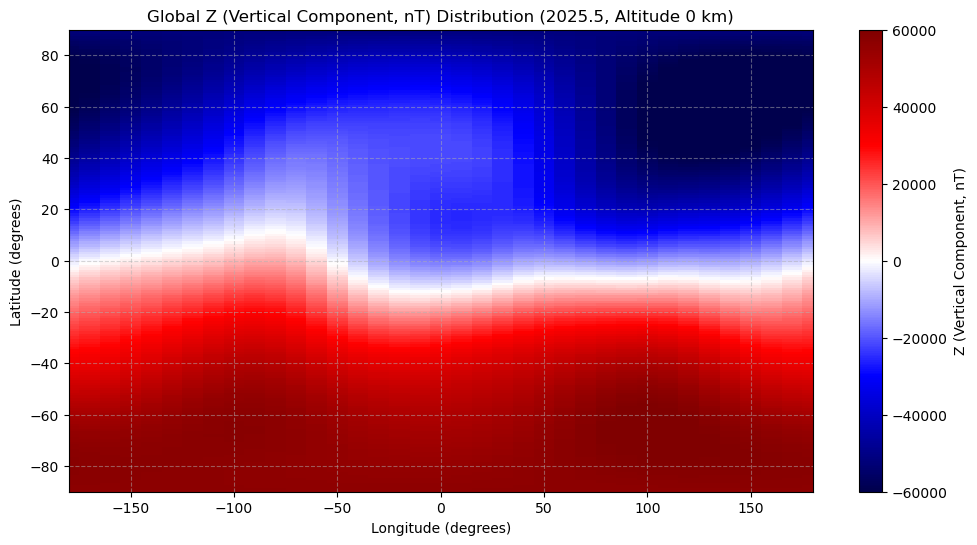

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm


def parse_igrf_file(filename):
    data = []
    with open(filename, 'r') as f:
        lines = f.readlines()

        start_line = 0
        for i, line in enumerate(lines):
            if line.strip().startswith('Lat     Long'):
                start_line = i + 1
                break

        for line in lines[start_line:]:
            if line.strip() and not line.strip().startswith('D is declination'):

                parts = line.split()
                if len(parts) == 9:
                    lat = float(parts[0])
                    lon = float(parts[1])
                    D = float(parts[2])
                    I = float(parts[3])
                    H = float(parts[4])
                    X = float(parts[5])
                    Y = float(parts[6])
                    Z = float(parts[7])
                    F = float(parts[8])
                    data.append([lat, lon, D, I, H, X, Y, Z, F])

    df = pd.DataFrame(data, columns=['Lat', 'Lon', 'D', 'I', 'H', 'X', 'Y', 'Z', 'F'])
    return df


def prepare_grids(df):

    lats = np.sort(df['Lat'].unique())[::-1]  
    lons = np.sort(df['Lon'].unique()) 
    
   
    lons = np.arange(-180, 190, 10) 
    

    
    Lon, Lat = np.meshgrid(lons, lats)
    
    
    def pivot_field(field):
        piv = df.pivot(index='Lat', columns='Lon', values=field)
        
        piv = piv.reindex(columns=np.arange(-180, 190, 10))
        return piv.values
    
    fields = {}
    for col in ['D', 'I', 'H', 'X', 'Y', 'Z', 'F']:
        fields[col] = pivot_field(col)
    
    return Lat, Lon, fields


def plot_global_field(Lat, Lon, field_data, field_name, cmap='viridis', title=None, vmin=None, vmax=None):
    fig, ax = plt.subplots(figsize=(12, 6))
    norm = Normalize(vmin=vmin, vmax=vmax)
    
    
    pcm = ax.pcolormesh(Lon, Lat, field_data, shading='auto', cmap=cmap, norm=norm)
    
   
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlabel('Longitude (degrees)')
    ax.set_ylabel('Latitude (degrees)')
    ax.set_title(title or f'Global {field_name} Distribution (2025.5, Altitude 0 km)')
    
   
    cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label(field_name)
    

    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    
    plt.show()


if __name__ == "__main__":
    filename = 'output.txt'  
    df = parse_igrf_file(filename)
    print(f"Parsed {len(df)} data points.")
    
    Lat, Lon, fields = prepare_grids(df)
    
    
    plot_global_field(Lat, Lon, fields['F'], 'F (Total Intensity, nT)', cmap='plasma', vmin=25000, vmax=65000)
    

    plot_global_field(Lat, Lon, fields['I'], 'I (Inclination, degrees)', cmap='RdBu', vmin=-90, vmax=90)
    

    plot_global_field(Lat, Lon, fields['D'], 'D (Declination, degrees)', cmap='hsv', vmin=-180, vmax=180)
    

    plot_global_field(Lat, Lon, fields['H'], 'H (Horizontal Intensity, nT)', cmap='viridis', vmin=0, vmax=50000)
    

    plot_global_field(Lat, Lon, fields['X'], 'X (North Component, nT)', cmap='coolwarm', vmin=-30000, vmax=30000)
    

    plot_global_field(Lat, Lon, fields['Y'], 'Y (East Component, nT)', cmap='coolwarm', vmin=-20000, vmax=20000)
    
 
    plot_global_field(Lat, Lon, fields['Z'], 'Z (Vertical Component, nT)', cmap='seismic', vmin=-60000, vmax=60000)

Parsed 6697 data points.


/Users/yongce/anaconda3/envs/ast_work/lib/python3.11/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/yongce/anaconda3/envs/ast_work/lib/python3.11/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


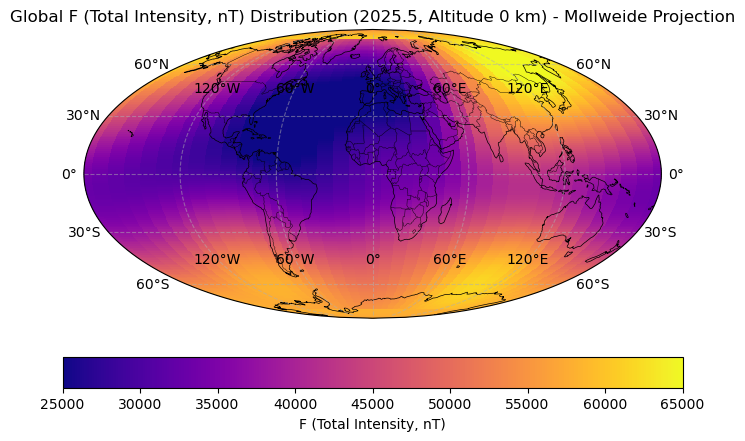

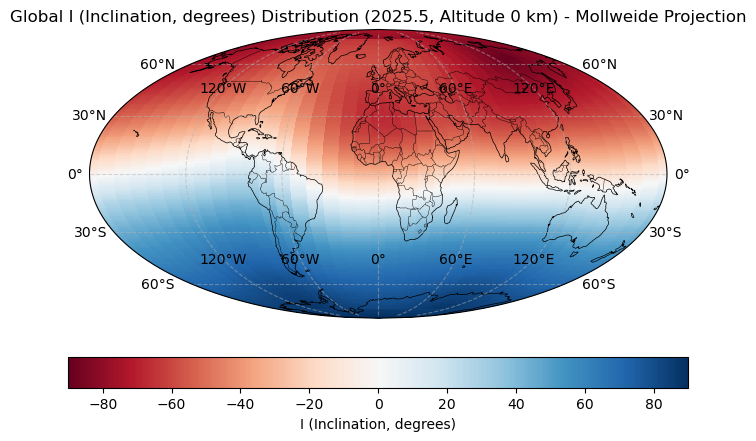

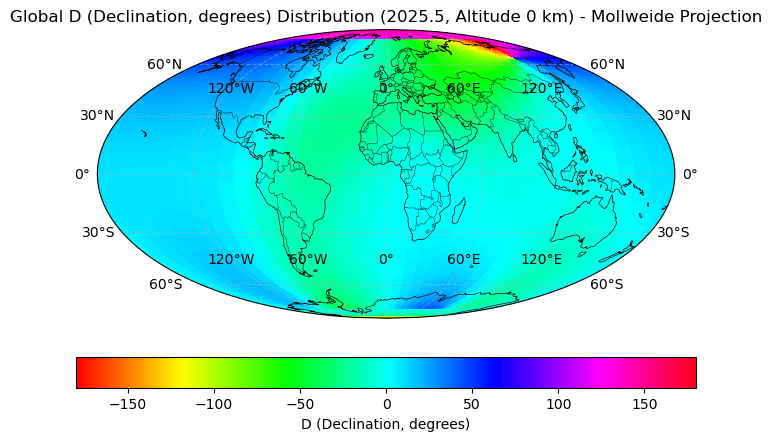

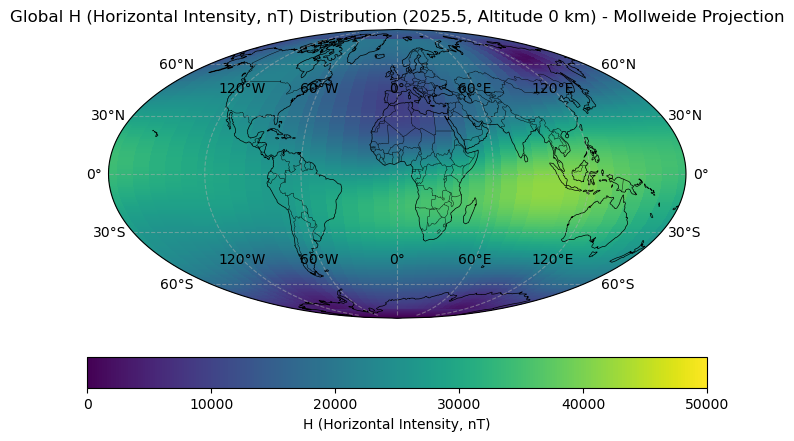

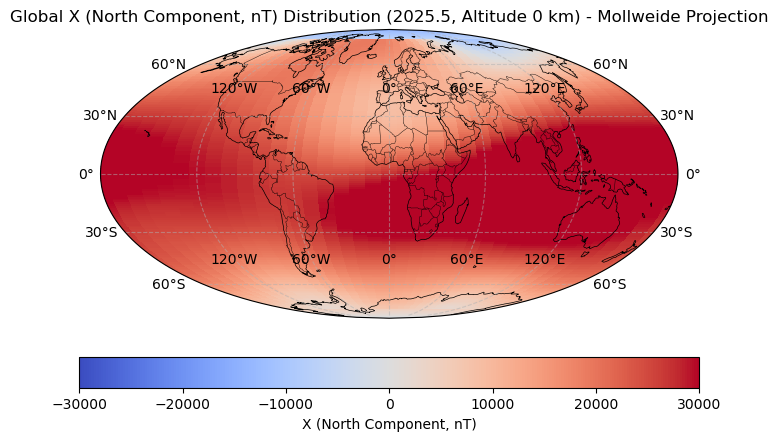

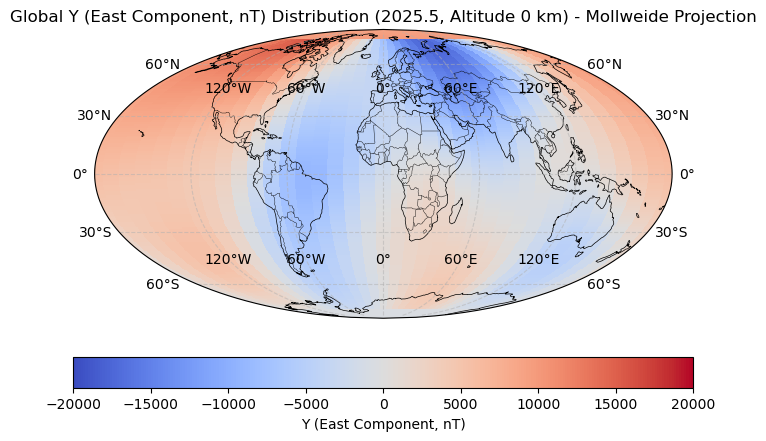

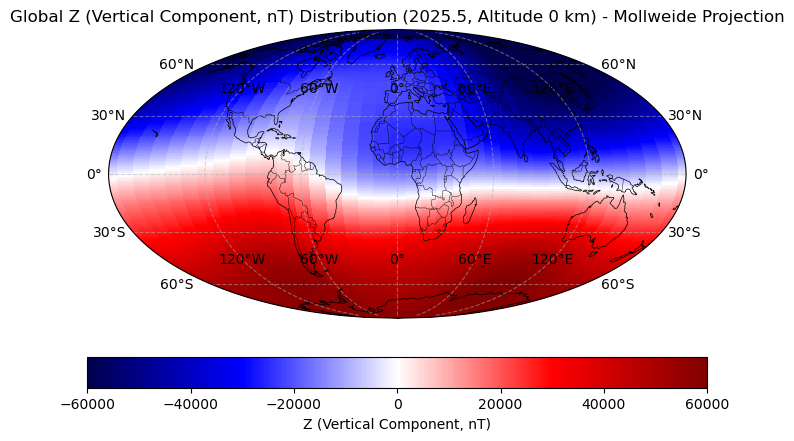

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import cartopy.crs as ccrs 
import cartopy.feature as cfeature


def parse_igrf_file(filename):
    data = []
    with open(filename, 'r') as f:
        lines = f.readlines()
        start_line = 0
        for i, line in enumerate(lines):
            if line.strip().startswith('Lat     Long'):
                start_line = i + 1
                break
        for line in lines[start_line:]:
            if line.strip() and not line.strip().startswith('D is declination'):
                parts = line.split()
                if len(parts) == 9:
                    lat = float(parts[0])
                    lon = float(parts[1])
                    if lon > 180:  # 调整经度到-180到180
                        lon -= 360
                    D = float(parts[2])
                    I = float(parts[3])
                    H = float(parts[4])
                    X = float(parts[5])
                    Y = float(parts[6])
                    Z = float(parts[7])
                    F = float(parts[8])
                    data.append([lat, lon, D, I, H, X, Y, Z, F])
    df = pd.DataFrame(data, columns=['Lat', 'Lon', 'D', 'I', 'H', 'X', 'Y', 'Z', 'F'])
    return df


def prepare_grids(df):

    lats = np.sort(df['Lat'].unique())[::-1]  # 90到-90
    lons = np.sort(df['Lon'].unique())  # -180到180
    Lon, Lat = np.meshgrid(lons, lats)
    

    def pivot_field(field):
        piv = df.pivot(index='Lat', columns='Lon', values=field)
        return piv.values
    
    fields = {}
    for col in ['D', 'I', 'H', 'X', 'Y', 'Z', 'F']:
        fields[col] = pivot_field(col)
    
    return Lat, Lon, fields


def plot_mollweide_field(Lat, Lon, field_data, field_name, cmap, title=None, vmin=None, vmax=None):
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.Mollweide())  
    ax.set_global()
    

    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    

    ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
    

    pcm = ax.pcolormesh(Lon, Lat, field_data, transform=ccrs.PlateCarree(),
                        cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
    

    ax.set_title(title or f'Global {field_name} Distribution (2025.5, Altitude 0 km) - Mollweide Projection')
    cbar = fig.colorbar(pcm, ax=ax, orientation='horizontal', pad=0.1, shrink=0.8)
    cbar.set_label(field_name)
    
    plt.show() 


if __name__ == "__main__":
    filename = 'output.txt' 
    df = parse_igrf_file(filename)
    print(f"Parsed {len(df)} data points.")
    
    Lat, Lon, fields = prepare_grids(df)
    

 
    plot_mollweide_field(Lat, Lon, fields['F'], 'F (Total Intensity, nT)', cmap='plasma', vmin=25000, vmax=65000)
    

    plot_mollweide_field(Lat, Lon, fields['I'], 'I (Inclination, degrees)', cmap='RdBu', vmin=-90, vmax=90)
    

    plot_mollweide_field(Lat, Lon, fields['D'], 'D (Declination, degrees)', cmap='hsv', vmin=-180, vmax=180)
    

    plot_mollweide_field(Lat, Lon, fields['H'], 'H (Horizontal Intensity, nT)', cmap='viridis', vmin=0, vmax=50000)
    

    plot_mollweide_field(Lat, Lon, fields['X'], 'X (North Component, nT)', cmap='coolwarm', vmin=-30000, vmax=30000)
    

    plot_mollweide_field(Lat, Lon, fields['Y'], 'Y (East Component, nT)', cmap='coolwarm', vmin=-20000, vmax=20000)
    

    plot_mollweide_field(Lat, Lon, fields['Z'], 'Z (Vertical Component, nT)', cmap='seismic', vmin=-60000, vmax=60000)